In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')
import torch
import matplotlib.pyplot as plt
from eigenpsf import EigenPSF
from tqdm import tqdm

In [2]:
torch.set_default_dtype(torch.float32)

## Camera parameters

In [3]:
camera_pixelpitch = 3.45e-6 #[m]
f = 1813e-6  # focal length of metalens
image_pixels = 512 #number of image pixels
image_size = camera_pixelpitch * image_pixels #actual image size formed in [m].
object_size = image_size / f #original object size in [m]
obj_coord_x = torch.linspace(-object_size/2, object_size/2, image_pixels)
obj_coord_y = torch.linspace(-object_size/2, object_size/2, image_pixels)
obj_coords = [obj_coord_x, obj_coord_y]

## Import measured PSFs
Recall that the PSFs are functions of 4 coordinates: $p(u,v,x,y)$, where $(u,v)$ denote the location of the point emitter on the object plane, and $(x,y)$ denote the spatial coordinates of the PSF on the imaging plane.

In this section, <code>psf_coords_u</code> and <code>psf_coords_v</code> contain the coordinates of the point emitter which gives rise to the 2D image of the PSF on the detector in the $(x,y)$ coordinates.

The PSFs might be flipped due to image inversion during image formation. But in this case it does not matter as our imaging system is circularly symmetric.

In [4]:
psfs = torch.load('../data/measured_psfs/psfs.pt').type(torch.float32)
psf_coords_u = torch.load('../data/measured_psfs/psfs_coordinates_u.pt').type(torch.float32)
psf_coords_v = torch.load('../data/measured_psfs/psfs_coordinates_v.pt').type(torch.float32)
psf_coords = [psf_coords_u, psf_coords_v]

In [5]:
psf_sh = psfs.shape[-1]
psf_x = (torch.arange(psf_sh) - psf_sh//2) * camera_pixelpitch
psf_y = (torch.arange(psf_sh) - psf_sh//2) * camera_pixelpitch

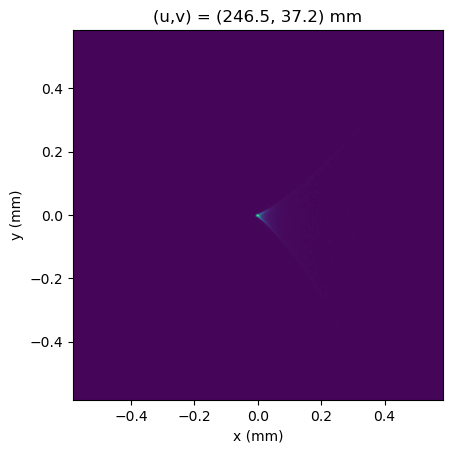

In [6]:
#view the ith psf
i = 250
plt.imshow(psfs[i], extent=[psf_x[0]*1e3, psf_x[-1]*1e3, psf_y[0]*1e3, psf_y[-1]*1e3])
plt.title(f'(u,v) = ({psf_coords_u[i]*1e3:.1f}, {psf_coords_v[i]*1e3:.1f}) mm')
plt.xlabel(r'x (mm)')
plt.ylabel(r'y (mm)')
plt.show()

## Import dataset

In [7]:
groundtruth_images = torch.load('../data/training_dataset/groundtruth_images.pt')
groundtruth_images.shape

torch.Size([4000, 512, 512])

## Constructing eigenPSFs and eigencoefficients

In [8]:
device = 'cuda:0'
eig = EigenPSF(groundtruth_images[0], psfs, psf_coords, obj_coords, tile_shape='nongridded', device=device)

In [9]:
# create eigenPSFs
eig.create_eigenpsfs()

Eigen PSF computation took 6 seconds


In [10]:
# create eigencoefficients
eig.create_eigencoeffs_nongridded()

Eigen coefficients computation took 15 seconds


In [11]:
# create normalizing mask
eig.normalizing_mask(n_components=None)
mask = eig.mask

Eigen convolution took 0 seconds


In [12]:
img = eig.eigen_convolution(n_components=None)

Eigen convolution took 0 seconds


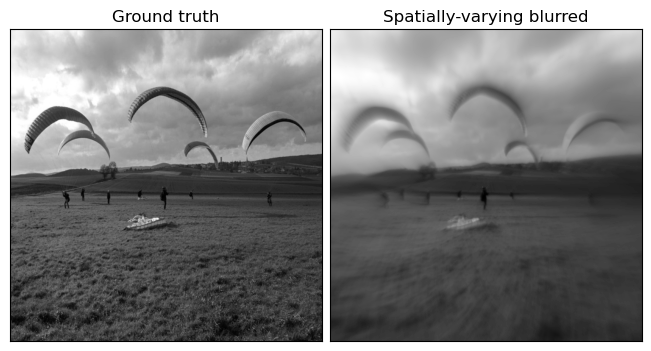

In [13]:
fig, axes = plt.subplots(1,2,dpi=100, constrained_layout=True)
[ax.set(xticks=[], yticks=[]) for ax in axes.ravel()]
ax = axes[0]
ax.imshow(groundtruth_images[0], cmap='grey')
ax.set_title('Ground truth')
ax = axes[1]

ax.imshow((img/mask).cpu(), cmap='grey')
ax.set_title('Spatially-varying blurred')
plt.show()

## Blurring all images

In [14]:
blurred = []

In [15]:
eig.verbose = False
for img in tqdm(groundtruth_images):
    # convolve
    eig.obj = img.to(device)
    eig.eigen_convolution()
    blur = eig.img / mask
    
    #normalize images to [0,1]
    blur = (blur - torch.min(blur)) / (torch.max(blur) - torch.min(blur))
    blur[blur < 0] = 0
    blurred.append(blur.detach().cpu())

blurred = torch.stack(blurred)

100%|███████████████████████████████████████| 4000/4000 [10:40<00:00,  6.25it/s]


In [16]:
# torch.save(blurred.detach().cpu(), '../data/training_dataset/blurred_images_new.pt')

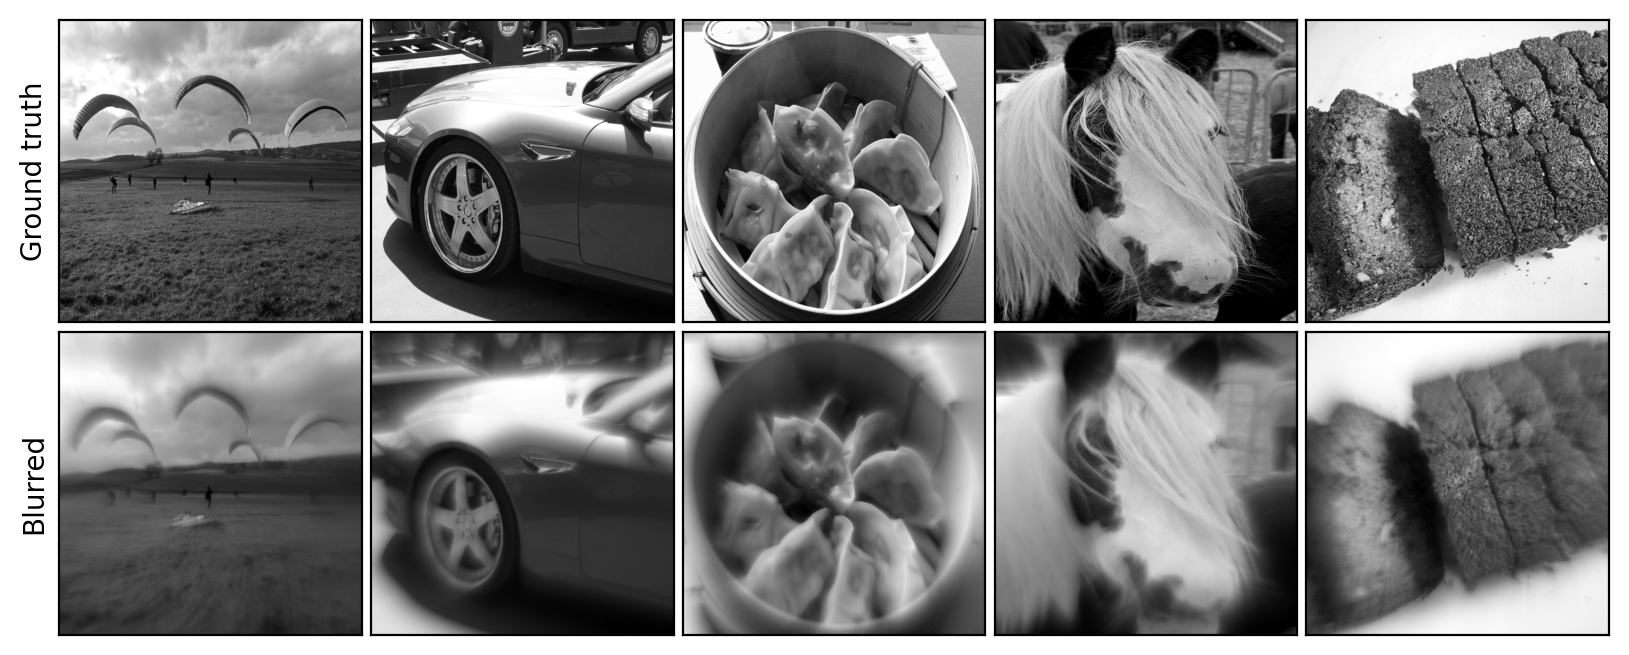

In [17]:
fig, axes = plt.subplots(2, 5, dpi=200, figsize=(10,4))

for i in range(5):
    axes[0,i].imshow(groundtruth_images[i], vmin=0, vmax=1, cmap='grey')
    axes[0,i].set(xticks=[], yticks=[])
    axes[1,i].imshow(blurred[i], vmin=0, vmax=1, cmap='grey')
    axes[1,i].set(xticks=[], yticks=[])
axes[0,0].set(ylabel='Ground truth')
axes[1,0].set(ylabel='Blurred')
plt.subplots_adjust(hspace=0.03, wspace=0.03)